In [1]:
DATASET_PATH = "output_frames_tot.csv"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [2]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

2025-03-16 20:26:28.410477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742153188.579026    6881 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742153188.625155    6881 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 20:26:29.045897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

Compute capability: (7, 5)
Turn on mixed_float16


In [4]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [6]:

if (not os.path.exists(DATASET_PATH)):
    print("Error: Dataset not found.")
    sys.exit()

In [7]:
df = pd.read_csv(DATASET_PATH, header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [8]:
print(dataset.shape)

(650956, 400)


In [9]:
dataset = dataset.reshape(dataset.shape[0], 25, 16, 1)
input_shape = dataset[0].shape

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {input_shape}")

Dataset shape: (650956, 25, 16, 1)
Labels shape: (650956,)
Input shape: (25, 16, 1)


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [10]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


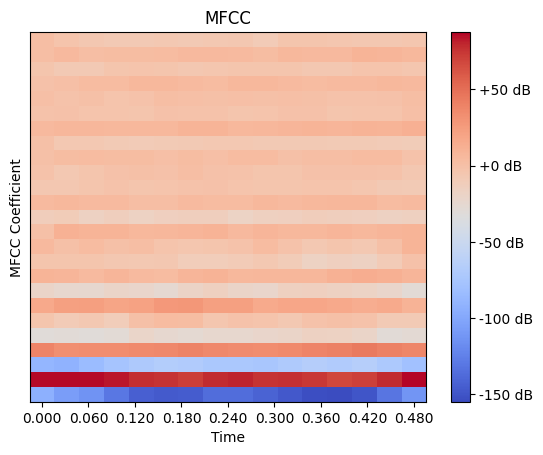

In [11]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [12]:
# Split the dataset into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 520764
Testing set length: 130192


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [14]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bus' 'Car' 'Motorcycle' 'Truck']


In [15]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))

# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [16]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [17]:
from keras.callbacks import EarlyStopping

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.25,
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping],
    )
    # Print history
    if doPrintHistory: printHistory(history)

# Construct Sequantial Model

...

In [ ]:
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

sequential_model = Sequential([

    Conv2D(filters=256, kernel_size=3, activation="relu", padding='same', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),

    Conv2D(filters=512, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),

    Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=1024, kernel_size=2, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),

    GlobalMaxPooling2D(),  # Instead of Flatten

    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(units=len(np.unique(labels_set)), activation="softmax")
])

In [19]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()

In [34]:
compileModel(sequential_model, 0.0003)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 25, 16, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 25, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 25, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 25, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 8, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12, 8, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 8, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 8, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 4, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 6, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 6, 4, 1024)     │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 6, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_4          │ (None, 1024)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,325,573 (50.83 MB)

 Trainable params: 13,318,405 (50.81 MB)

 Non-trainable params: 7,168 (28.00 KB)

Epoch 1/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.2269 - loss: 2.9330

2025-03-16 21:40:07.057711: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_20', 16 bytes spill stores, 16 bytes spill loads



6103/6103 ━━━━━━━━━━━━━━━━━━━━ 144s 22ms/step - categorical_accuracy: 0.2269 - loss: 2.9328 - val_categorical_accuracy: 0.2322 - val_loss: 1.5903
Epoch 2/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 128s 21ms/step - categorical_accuracy: 0.2352 - loss: 1.4874 - val_categorical_accuracy: 0.3000 - val_loss: 1.5463
Epoch 3/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 126s 21ms/step - categorical_accuracy: 0.2988 - loss: 1.4219 - val_categorical_accuracy: 0.3099 - val_loss: 1.4252
Epoch 4/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 127s 21ms/step - categorical_accuracy: 0.3083 - loss: 1.3744 - val_categorical_accuracy: 0.3138 - val_loss: 1.4492
Epoch 5/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 127s 21ms/step - categorical_accuracy: 0.3220 - loss: 1.3496 - val_categorical_accuracy: 0.3060 - val_loss: 1.4296
Epoch 6/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 126s 21ms/step - categorical_accuracy: 0.3340 - loss: 1.3130 - val_categorical_accuracy: 0.3684 - val_loss: 1.3790
Epoch 7/16
6103/6103 ━━━━━━━━━━━━━━━━━━━━ 127s 21ms/step - categorica

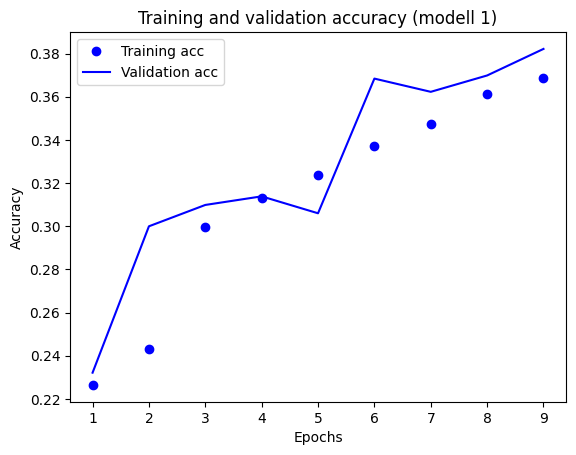

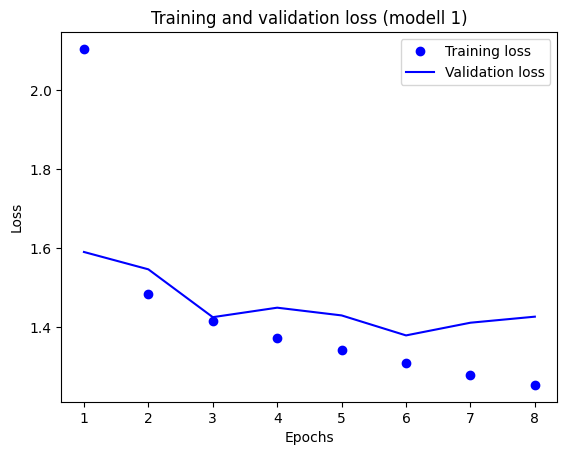

In [35]:
fitModel(sequential_model, x_train, y_train, 16, True, dist_class_weight, 1, 64)

In [32]:
# Test the model.
test_loss, test_accuracy = sequential_model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

4069/4069 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - categorical_accuracy: 0.7124 - loss: 0.8073
Test loss: 0.8128311634063721
Test accuracy: 0.7115107178688049
